In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

### Generate a time series from IID Gaussian random process

In [2]:
mu, sigma = 0, 1
size = 10000
iid_gaussian_series = np.random.normal(mu, sigma, size)

Run the ADF test on the IID Gaussian series.\
It should reject the hypothesis that the series has unit root and is not stationary

In [3]:
adf_result = adfuller(iid_gaussian_series)
print(adf_result)
print("ADF statistic: {}".format(adf_result[0]))

if adf_result[0] < adf_result[4]['1%']:
    print("The series is stationary with significance level at 1%")

(-100.10576938573983, 0.0, 0, 9999, {'1%': -3.4310041633725734, '5%': -2.861829101294412, '10%': -2.566923883481157}, 28280.14472936409)
ADF statistic: -100.10576938573983
The series is stationary with significance level at 1%


#### Run ADF test on the cumsum of Gaussian IID

Compute the first differentation and run ADF test

In [4]:
order = 0
significance_level = "1%"
gaussian_series_cumsum = np.cumsum(iid_gaussian_series)
series_diff = gaussian_series_cumsum
while True:
    adf_test = adfuller(series_diff)
    print("ADF statistic is {}, and critical values are {}".format(adf_test[0], adf_test[4]))
    if adf_test[0] < adf_test[4][significance_level]:
        print("This series has the order integration of {} with significance level at {}".format(order, significance_level))
        break
    series_diff = np.diff(series_diff)
    order += 1

ADF statistic is 0.3050207983553137, and critical values are {'1%': -3.4310041633725734, '5%': -2.861829101294412, '10%': -2.566923883481157}
ADF statistic is -100.10114347817454, and critical values are {'1%': -3.431004228818807, '5%': -2.8618291302145686, '10%': -2.566923898875394}
This series has the order integration of 1 with significance level at 1%


In [5]:
adf_cumsum = adfuller(gaussian_series_cumsum)
print("p-value of ADF on the cumsum series is {:.2f}".format(adf_cumsum[1]))

p-value of ADF on the cumsum series is 0.98


Differentiate the cumsum series twice and run ADF test to get the p-value

In [6]:
adf_cumsum_diff_twice = adfuller(np.diff(np.diff(gaussian_series_cumsum)))
print("p-value of ADF on the diff-twice cumsum is {:.2f}".format(adf_cumsum_diff_twice[1]))

p-value of ADF on the diff-twice cumsum is 0.00


### Time series follows a sinusoidal function

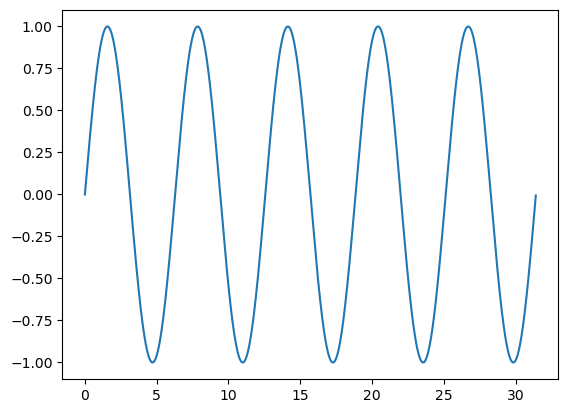

In [7]:
step = 0.01
cycle = 10
x_values = np.arange(0, cycle * np.pi, step)
y_values = np.sin(x_values)
plt.plot(x_values, y_values)

In [8]:
sin_adf = adfuller(y_values)
print(sin_adf)
print("The p-value of the sinusoidal function is {}".format(sin_adf[1]))

(-2367566588027.452, 0.0, 1, 3140, {'1%': -3.432434284686715, '5%': -2.86246090842951, '10%': -2.5672602212057285}, -202900.55022779622)
The p-value of the sinusoidal function is 0.0


Shift every observation with the same positive value, then compute the cumsum

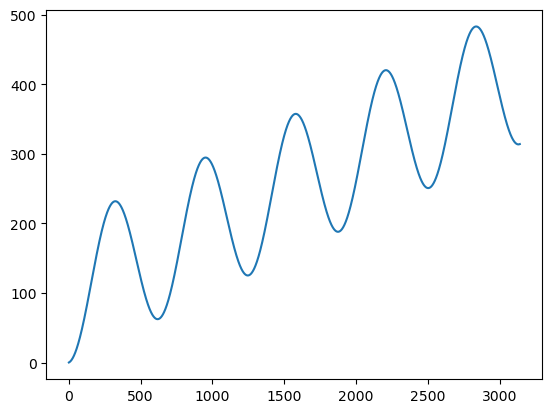

In [9]:
shifted_val = 0.1
cumsum_shifted_sin = np.cumsum(y_values + shifted_val)
plt.plot(cumsum_shifted_sin)

In [10]:
shifted_adf = adfuller(cumsum_shifted_sin)
print(shifted_adf)
print("The p-value of the cumsum of shifted sinusoidal function is {}".format(shifted_adf[1]))

(17.532169199683036, 1.0, 23, 3118, {'1%': -3.4324490031269144, '5%': -2.862467409249606, '10%': -2.567263682135347}, -189682.47358694015)
The p-value of the cumsum of shifted sinusoidal function is 1.0


#### Implementing fractional differentiation with expanding window and fixed window

In [11]:
def get_weights(N, d):
    weights = np.zeros(N)
    weights[0] = 1
    # w_k = -w_{k-1} * (d-k+1) / k
    for k in range(1, N):
        weights[k] = -weights[k-1] * (d-k+1) / k

    return weights

In [12]:
def get_weights_expanding_window_fracdiff(ts, d, threshold):
    # Compute the sum of weights up to the length of the timeseries
    # Compute the memory loss at each index
    # Find the index l* where loss(l*) <= tau < loss(l*+1
    
    N = len(ts)
    weights = get_weights(N, d)

    # cumsum[k] = sum_i=0_k abs(w_i)
    weight_cumsum = np.cumsum(np.abs(weights))
    weight_usage = weight_cumsum / weight_cumsum[-1]
    weight_loss = 1 - weight_usage
    # Get the window where weigh usage is larger than threshold
    window_size = np.sum(weight_loss > threshold)
    
    return weights[:window_size]

In [13]:
def get_weights_fixed_window_fracdiff(ts, d, threshold):
    N = len(ts)
    weights = get_weights(N, d)
    # Only keep weights with absolute values that are larger than threshold
    return weights[np.abs(weights) > threshold]

In [14]:
def frac_diff(ts, d, threshold, type):
    if d==0:
        return ts
    elif d==1:
        return np.diff(ts)
    
    weights = None
    if type=="expanding":
        weights = get_weights_expanding_window_fracdiff(ts, d, threshold)
    elif type=="fixed":
        weights = get_weights_fixed_window_fracdiff(ts, d, threshold)

    if weights is None or len(weights) == len(ts):
        # print("Weights is None OR The window size is N")
        return []
        

    diff_ts = []
    window_size = len(weights)
    for k in range(window_size, len(ts)):
        x_values = ts[k+1-window_size:k+1]
        diff_val = np.dot(x_values, np.flip(weights))
        diff_ts.append(diff_val)

    return np.array(diff_ts)

#### Find the minimum differentiation degree with p-value < 5%

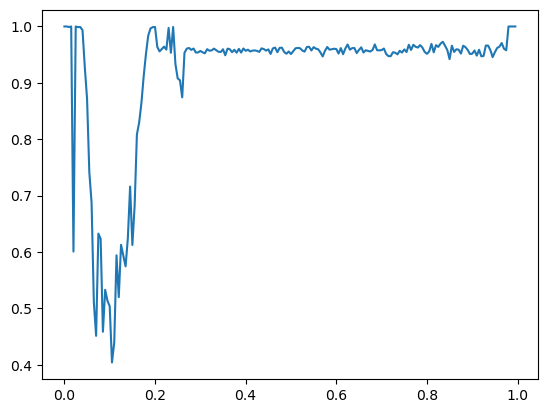

In [23]:
expanding_wd_tau = 1e-2
expanding_degrees = []
expanding_p_value = []

for d in np.arange(0, 1, 0.005):
    # print("Differentiating with d={}".format(d))
    fracdiff_ts = frac_diff(cumsum_shifted_sin, d, expanding_wd_tau, 'expanding')
    if len(fracdiff_ts) == 0:
        continue
    
    # print("len={}".format(len(fracdiff_ts)))
    adf_test = adfuller(fracdiff_ts)
    # print("d={:.2f}, p-value={:.2f}".format(d, adf_test[1]))

    expanding_degrees.append(d)
    expanding_p_value.append(adf_test[1])

plt.plot(expanding_degrees, expanding_p_value)

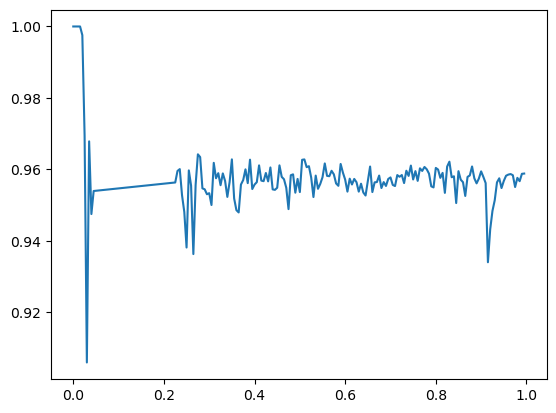

In [24]:
fixed_wd_tau = 1e-5
fixed_degrees = []
fixed_p_value = []

for d in np.arange(0, 1, 0.005):
    fracdiff_ts = frac_diff(cumsum_shifted_sin, d, fixed_wd_tau, 'fixed')
    if len(fracdiff_ts) == 0:
        continue
    # print("len={}".format(len(fracdiff_ts)))
    adf_test = adfuller(fracdiff_ts)
    # print("d={:.2f}, p-value={:.2f}".format(d, adf_test[1]))
    
    fixed_degrees.append(d)
    fixed_p_value.append(adf_test[1])
plt.plot(fixed_degrees, fixed_p_value)